In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import itertools
from collections import Counter
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

C:\Users\11ana\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
data = pd.read_csv(r'C:\Users\11ana\Desktop\INSAID\Fraud.csv')
d1 = data

In [4]:
print(data.shape)
data.head(10)

(6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


In [5]:
null_values = data.isnull()
null_values.value_counts()

step   type   amount  nameOrig  oldbalanceOrg  newbalanceOrig  nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud
False  False  False   False     False          False           False     False           False           False    False             6362620
dtype: int64

In [6]:
legit = len(data[data.isFraud == 0])
fraud = len(data[data.isFraud == 1])
legit_percent = (legit / (fraud + legit)) * 100
fraud_percent = (fraud / (fraud + legit)) * 100

print("No. of Legit transactions : ", legit)
print("Legit transactions % : {:.4f} %".format(legit_percent))
print("No. of Fraud transactions : ", fraud)
print("Fraud transactions % : {:.4f} %".format(fraud_percent))

No. of Legit transactions :  6354407
Legit transactions % : 99.8709 %
No. of Fraud transactions :  8213
Fraud transactions % : 0.1291 %


<AxesSubplot:>

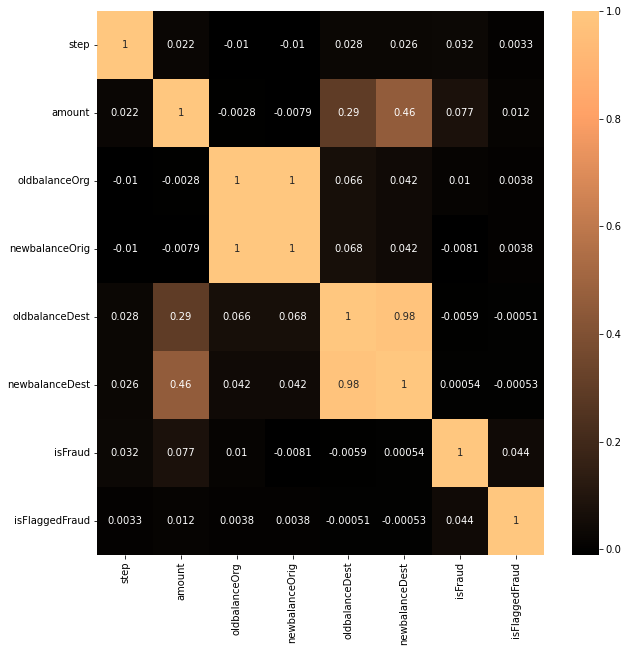

In [7]:
corr = data.corr()

plt.figure(figsize=(10,10))

sns.heatmap(corr,annot=True, cmap = 'copper')

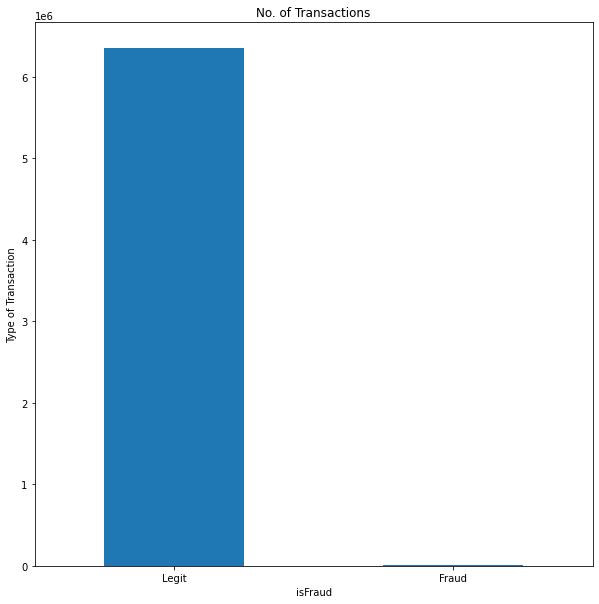

In [8]:
plt.figure(figsize=(10,10))
labels = ["Legit", "Fraud"]
count_classes = data.value_counts(data['isFraud'], sort= True)
count_classes.plot(kind = "bar", rot = 0)
plt.title("No. of Transactions")
plt.ylabel("Type of Transaction")
plt.xticks(range(2), labels)
plt.show()

In [9]:
obj1 = d1.select_dtypes(include = "object").columns
print(obj1)

Index(['type', 'nameOrig', 'nameDest'], dtype='object')


In [10]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for feat in obj1:
    d1[feat] = le.fit_transform(d1[feat].astype(str))

print(d1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            int32  
 2   amount          float64
 3   nameOrig        int32  
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        int32  
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int32(3), int64(3)
memory usage: 461.2 MB
None


In [11]:
def vif_score(df):
    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

    return(vif)

In [12]:
vif_score(d1)

,variables,VIF
0,step,2.791610
1,type,4.467405
2,amount,4.149312
3,nameOrig,2.764234
4,oldbalanceOrg,576.803777
5,newbalanceOrig,582.709128
6,nameDest,3.300975
7,oldbalanceDest,73.349937
8,newbalanceDest,85.005614
9,isFraud,1.195305


In [13]:
d1['Actual_amount_orig'] = d1.apply(lambda x: x['oldbalanceOrg'] - x['newbalanceOrig'],axis=1)
d1['Actual_amount_dest'] = d1.apply(lambda x: x['oldbalanceDest'] - x['newbalanceDest'],axis=1)
d1['TransactionPath'] = d1.apply(lambda x: x['nameOrig'] + x['nameDest'],axis=1)

d1 = d1.drop(['oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','step','nameOrig','nameDest'],axis=1)

In [14]:
vif_score(d1)

,variables,VIF
0,type,2.687803
1,amount,3.818902
2,isFraud,1.184479
3,isFlaggedFraud,1.002546
4,Actual_amount_orig,1.307910
5,Actual_amount_dest,3.754335
6,TransactionPath,2.677167


<AxesSubplot:>

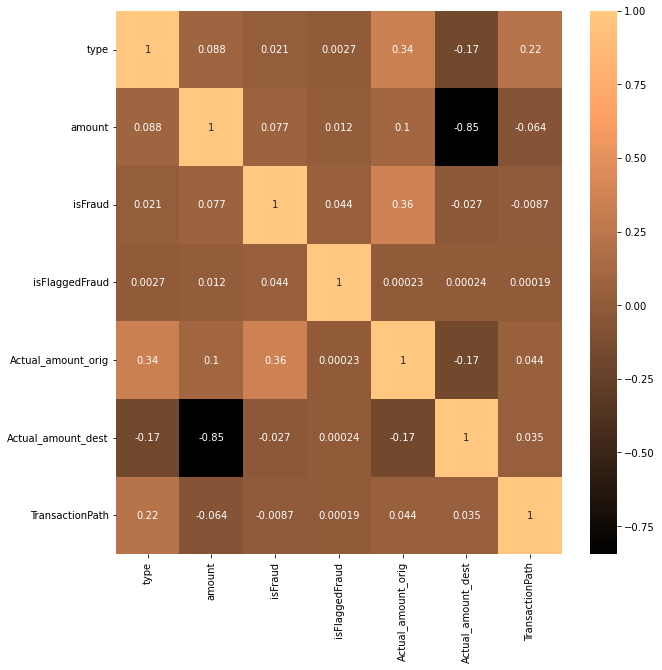

In [16]:
corr= d1.corr()

plt.figure(figsize=(10,10))
sns.heatmap(corr,annot=True, cmap = 'copper')

In [17]:
scaler = StandardScaler()
d1["NormalizedAmount"] = scaler.fit_transform(d1["amount"].values.reshape(-1, 1))
d1.drop(["amount"], inplace= True, axis= 1)

Y = d1["isFraud"]
X = d1.drop(["isFraud"], axis= 1)

In [18]:
(X_train, X_test, Y_train, Y_test) = train_test_split(X, Y, test_size= 0.25, random_state= 101)

print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)

Shape of X_train:  (4771965, 6)
Shape of X_test:  (1590655, 6)


In [19]:
dec_tree = DecisionTreeClassifier()
dec_tree.fit(X_train, Y_train)

pred_dt = dec_tree.predict(X_test)
dec_tree_score = dec_tree.score(X_test, Y_test) * 100

In [20]:
ran_for = RandomForestClassifier(n_estimators= 100)
ran_for.fit(X_train, Y_train)

pred_rf = ran_for.predict(X_test)
ran_for_score = ran_for.score(X_test, Y_test) * 100

In [21]:
xg_boost = XGBClassifier()
xg_boost.fit(X_train,Y_train)

pred_xg = xg_boost.predict(X_test)
xg_boost_score = xg_boost.score(X_test, Y_test) * 100

C:\Users\11ana\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\11ana\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[19:21:32] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [22]:
print("Decision Tree Score: ", dec_tree_score)
print("Random Forest Score: ", ran_for_score)
print("XGBoost Score: ", xg_boost_score)

Decision Tree Score:  99.92298770003552
Random Forest Score:  99.95888486189651
XGBoost Score:  99.95995360401847


In [23]:
# DT - key terms of Confusion Matrix 

print("TP,FP,TN,FN - Decision Tree")
tn, fp, fn, tp = confusion_matrix(Y_test, pred_dt).ravel()
print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')

print("----------------------------------------------------------------------------------------")

# RF - key terms of Confusion Matrix 

print("TP,FP,TN,FN - Random Forest")
tn, fp, fn, tp = confusion_matrix(Y_test, pred_rf).ravel()
print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')

print("----------------------------------------------------------------------------------------")

# XGB - key terms of Confusion Matrix 

print("TP,FP,TN,FN - XGBoost")
tn, fp, fn, tp = confusion_matrix(Y_test, pred_xg).ravel()
print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')

TP,FP,TN,FN - Decision Tree
True Positives: 1439
False Positives: 647
True Negatives: 1587991
False Negatives: 578
----------------------------------------------------------------------------------------
TP,FP,TN,FN - Random Forest
True Positives: 1428
False Positives: 65
True Negatives: 1588573
False Negatives: 589
----------------------------------------------------------------------------------------
TP,FP,TN,FN - XGBoost
True Positives: 1421
False Positives: 41
True Negatives: 1588597
False Negatives: 596


In [24]:
#  DT confusion matrix

confusion_matrix_dt = confusion_matrix(Y_test, pred_dt.round())
print("Confusion Matrix - Decision Tree")
print(confusion_matrix_dt)

print("----------------------------------------------------------------------------------------")

#  RF confusion matrix

confusion_matrix_rf = confusion_matrix(Y_test, pred_rf.round())
print("Confusion Matrix - Random Forest")
print(confusion_matrix_rf)

print("----------------------------------------------------------------------------------------")

# XGB confusion matrix

confusion_matrix_xg = confusion_matrix(Y_test, pred_xg.round())
print("Confusion Matrix - XGBoost")
print(confusion_matrix_xg)

Confusion Matrix - Decision Tree
[[1587991     647]
 [    578    1439]]
----------------------------------------------------------------------------------------
Confusion Matrix - Random Forest
[[1588573      65]
 [    589    1428]]
----------------------------------------------------------------------------------------
Confusion Matrix - XGBoost
[[1588597      41]
 [    596    1421]]


In [25]:
# DT classification report

classification_report_dt = classification_report(Y_test, pred_dt)
print("Classification Report - Decision Tree")
print(classification_report_dt)

print("----------------------------------------------------------------------------------------")

# RF classification report

classification_report_rf = classification_report(Y_test, pred_rf)
print("Classification Report - Random Forest")
print(classification_report_rf)

print("----------------------------------------------------------------------------------------")

# XGB classification report

classification_report_xg = classification_report(Y_test, pred_xg)
print("Classification Report - XGBoost")
print(classification_report_xg)

Classification Report - Decision Tree
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588638
           1       0.69      0.71      0.70      2017

    accuracy                           1.00   1590655
   macro avg       0.84      0.86      0.85   1590655
weighted avg       1.00      1.00      1.00   1590655

----------------------------------------------------------------------------------------
Classification Report - Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588638
           1       0.96      0.71      0.81      2017

    accuracy                           1.00   1590655
   macro avg       0.98      0.85      0.91   1590655
weighted avg       1.00      1.00      1.00   1590655

----------------------------------------------------------------------------------------
Classification Report - XGBoost
              precision    recall  f1-score   support

     

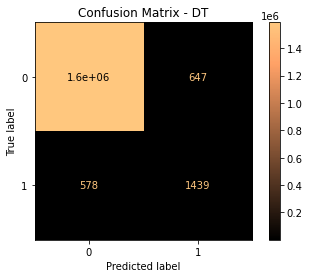

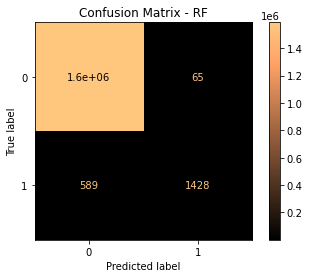

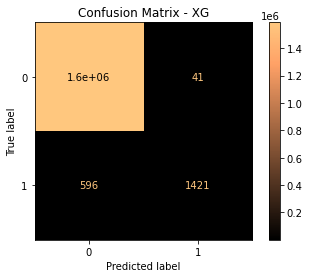

In [26]:
# DT visualising confusion matrix


disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_dt)
disp.plot(cmap = 'copper')
plt.title('Confusion Matrix - DT')
plt.show()

# RF visualising confusion matrix 
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_rf)
disp.plot(cmap = 'copper')
plt.title('Confusion Matrix - RF')
plt.show()

# XGB visualising confusion matrix 
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_xg)
disp.plot( cmap = 'copper')
plt.title('Confusion Matrix - XG')
plt.show()


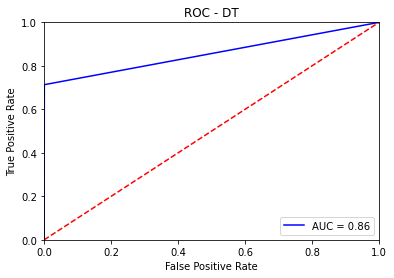

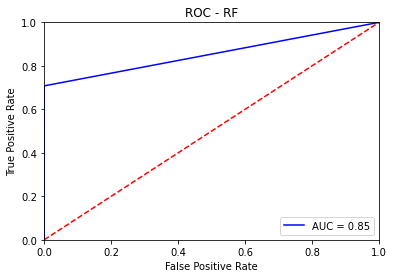

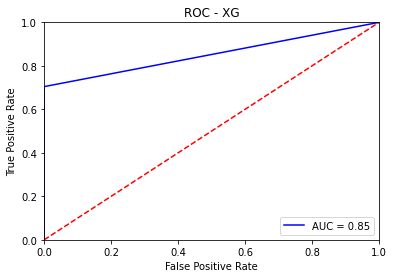

In [27]:
# DT - AUC ROC 

fpr, tpr, threshold = metrics.roc_curve(Y_test, pred_dt)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC - DT')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# RF - AUC ROC 

fpr, tpr, threshold = metrics.roc_curve(Y_test, pred_rf)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC - RF')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# XGB - AUC ROC

fpr, tpr, threshold = metrics.roc_curve(Y_test, pred_xg)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC - XG')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

THE AUC for both Decision Tree and Random Forest is equal, so both models are pretty good at what they do, but XGBoost doesn't seem to be doing a great job.

# CONCLUSION

We have seen that Accuracy of both XGBoost, Random Forest and Decision Tree is equal, although the precision of Random Forest is more and that of XGBoost is very poor. In a fraud detection model, Precision is highly important because rather than predicting normal transactions correctly we want Fraud transactions to be predicted correctly and Legit to be left off.If either of the 2 reasons are not fulfiiled we may catch the innocent and leave the culprit.
This is also one of the reason why Random Forest and Decision Tree are used instead of other algorithms.


Also the reason I have chosen this model is because of highly unbalanced dataset (Legit: Fraud :: 99.87:0.13). Random forest makes multiple decision trees which makes it easier (although time taking) for model to understand the data in a simpler way since Decision Tree makes decisions in a boolean way.

But XGBoost does not give good precision and recall which is more necessary over accuracy so it should not be considered.


Models like Bagging, ANN, and Logistic Regression may give good accuracy but they won't give good precision and recall values.

What are the key factors that predict fraudulent customer?

The source of request is secured or not ?
Is the name of organisation asking for money is legit or not ?
Transaction history of vendors.
What kind of prevention should be adopted while company update its infrastructure?

Use smart vertified apps only.
Browse through secured websites.
Use secured internet connections (USE VPN).
Keep your mobile and laptop security updated.
Don't respond to unsolicited calls/SMS(s/E-mails.
If you feel like you have been tricked or security compromised, contact your bank immidiately.
Assuming these actions have been implemented, how would you determine if they work?

Bank sending E-statements.
Customers keeping a check of their account activity.
Always keep a log of your payments.